# Housing data cleaning


### THE QUESTIONS
##### You must be able to answer :
1. Which variable is the target ? -> Price
2. How many rows and columns ?
3. What is the correlation between the variables and the target ? (Why might that be?)
4. What is the correlation between the variables and the other variables ? (Why?)
5. Which variables have the greatest influence on the target ?
6. Which variables have the least influence on the target ?
7. How many qualitative and quantitative variables are there ? How would you transform these values into numerical values ?
8. Percentage of missing values per column ?

In [367]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np



In [368]:
def read_df(filename: str) -> pd.DataFrame:
    """Reads a DataFrame from a binary file 
    :return: A DataFrame that contains all the data from ImmoWeb properties """
    open_file = open(filename, "rb")
    loaded_data = pickle.load(open_file)
    print(type(loaded_data))
    open_file.close()
    return loaded_data

houses = pd.read_csv('housing_data.csv')
houses.head()
houses.shape

(14625, 113)

In [369]:
len(houses.columns)


113

## Drop the unnecessary columns

## Then calculate again the number of columns

In [370]:
len(houses.columns)

113

## 1. Price (Jari)


### Removing empty sales values and rows with price range

Number of rows before

In [371]:
houses['Immoweb ID'].count()

14625

Count rows to remove

In [372]:
houses['Immoweb ID'].loc[houses['Price']!= houses['Price (sr only)']].count()

14625

#### Remove the rows

Rows after the remove

Convert the values to integers and check that it really happened

In [373]:
def price_empty_conv(value : str) -> str:
    if pd.isna(value) or pd.isnull(value):
        return value
    if len(value) > 10:
        return 'KILL_ME'
    return value

houses['Price'] = houses['Price'].apply(price_empty_conv)

In [374]:
houses[['Immoweb ID', 'Price']].loc[(houses['Price'].str.len()) > 10]

,Immoweb ID,Price


In [255]:
houses[['Immoweb ID', 'Price']].loc[houses['Price']== 'KILL_ME']
houses['Immoweb ID'].count()

14625

In [256]:
houses = houses[houses['Price'] != 'KILL_ME']
houses['Immoweb ID'].count()

14621

In [257]:
houses['Price'] = houses['Price'].astype('int')

In [258]:
houses['Price'].dtype

dtype('int64')

## 2. Living area (Jari)

#### Remove the rows that has no 'living area' information (and set the type to int)

In [259]:
houses = houses.loc[pd.notna(houses['Living area'])]
houses['Living area'] = houses['Living area'].astype('int')

In [260]:
houses['Immoweb ID'].count()

11446

## 3. Price / Square meter (eur/m2) (Jari)

#### Let's rename 'Price (sr only)' to 'Eur/m2'

In [261]:
houses = houses.rename(columns={'Price (sr only)': 'Eur/m2'})
houses.head(1)


,Unnamed: 0,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,0,9739983,APARTMENT,PENTHOUSE,476000,476000.0,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate the price/m2

In [262]:
houses['Eur/m2'] = (houses['Price'])/(houses['Living area'])


In [263]:
houses.head(1)

,Unnamed: 0,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,0,9739983,APARTMENT,PENTHOUSE,476000,3051.282051,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. The Building Condition

In [264]:
houses.groupby(['Building condition']).count().iloc[:,:1]


,Unnamed: 0
Building condition,
As new,3526
Good,3114
Just renovated,538
To be done up,743
To renovate,755
To restore,71


In [265]:
houses = houses.loc[pd.notna(houses['Building condition'])]

In [266]:
houses['Immoweb ID'].loc[pd.isna(houses['Building condition'])].count()

0

In [267]:
def building_condition_conv(value : str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'As new' or value == 'Just renovated':
        return 4
    elif value == 'Good':
        return 3
    elif value == 'To be done up':
        return 2
    elif value == 'To renovate':
        return 1
    elif value == 'To restore':
        return 0
    else:
        return value
    
houses['Building condition'] = houses['Building condition'].apply(building_condition_conv)



In [268]:
houses.count()



Unnamed: 0           8747
Immoweb ID           8747
Property type        8747
property sub-type    8747
Price                8747
                     ... 
Plot at rear          627
Percentage rented      68
EPC description         7
Venue of the sale       0
Date of the sale        0
Length: 113, dtype: int64

## Remove the duplicates (Jari)

#### It seems that there are no more duplicates after fixing the price issues and removing the properties without any living area information.

In [269]:
houses['Immoweb ID'].count() #11446 rows, 25 cols



8747

In [270]:
houses.drop_duplicates(subset=['Immoweb ID']) # No duplicates any more!
houses['Immoweb ID'].count() #11446 rows, 25 cols

8747

## EXTRA (Mission objectives: be able to think outside the box.)

Here is the idea: let's use as many columns as possible. For example, if a property has 'swimming pool' it could get 10 points. It an apartment has a elevator it makes for ex. 5 points and so on. All of these points will be sum up and normilized (scale would be from 0 to 5)

PROs
+ Coverage is high (100%)
+ We could get some benefit from the values like garden, terrace, full eguip kitchen and so on
+ Out of Box solution (that was requested in the task)


CONs
- some work to do (convert all the columns that will be used)



## 5. Swimming pool

In [271]:
houses.groupby(['Swimming pool']).count().iloc[:,:1]



,Unnamed: 0
Swimming pool,
No,3040
Yes,420


In [272]:
houses['Immoweb ID'].loc[pd.isna(houses['Swimming pool'])].count()


5287

A Swimming pool 10 points!   No: 3568, Yes: 502, NaN: 7376

In [273]:
def swimming_pool(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'Yes' or value == '10.0': #ten is there for the case that this code is re-run
        return 10
    elif value == 'No' or value == '0.0': #ten is there for the case that this code is re-run
        return 0
    else:
        return 3 


houses['Swimming pool'] = houses['Swimming pool'].apply(swimming_pool)

In [274]:
houses.head(1)

,Unnamed: 0,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Price HTML,Post code,Available as of,Property name,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
0,0,9739983,APARTMENT,PENTHOUSE,476000,3051.282051,"\n€476,000 476000€\n",1130,After signing the deed,MIDDLE WAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Let's change the type to numeric (there are some NaN's as well)

In [275]:
pd.to_numeric(houses['Swimming pool'], errors = 'coerce')


0         NaN
3         0.0
4         0.0
5         NaN
6         NaN
         ... 
14592     0.0
14609    10.0
14612     NaN
14614     NaN
14615     NaN
Name: Swimming pool, Length: 8747, dtype: float64

In [276]:
houses.groupby(['Swimming pool']).count().iloc[:,:1]

,Unnamed: 0
Swimming pool,
0.0,3040
10.0,420


## 6. Kitchen type

In [277]:
houses.groupby(['Kitchen type']).count().iloc[:,:1]


,Unnamed: 0
Kitchen type,
Hyper equipped,1509
Installed,2910
Not installed,333
Semi equipped,768
USA hyper equipped,703
USA installed,269
USA semi equipped,55
USA uninstalled,3


In [278]:
houses['Immoweb ID'].loc[pd.isna(houses['Kitchen type'])].count()


2197

Kitchen type max 15 points!  NaN: 3400

In [279]:
def kitchen_type(value: str) -> int:
    if pd.isna(value) or pd.isnull(value): 
        return value  #Keep NaN as Nan
    elif value == 'Hyper equipped' or value == 'USA hyper equipped' or value == 10:
        return 10
    elif value == 'Semi equipped' or value == 'USA semi equipped' or value == 7:
        return 7
    elif value == 'Installed' or value == 'USA installed' or value == 4:
        return 4
    elif value == 'Not installed'or value == 'USA uninstalled' or value == 0:
        return 0
    else:
        return 3 #just to notice the error


houses['Kitchen type'] = houses['Kitchen type'].apply(kitchen_type)

#### Let's change the type to numeric (there are some NaN's as well)

In [280]:
pd.to_numeric(houses['Kitchen type'], errors = 'coerce')


0        10.0
3         4.0
4        10.0
5        10.0
6         7.0
         ... 
14592    10.0
14609     NaN
14612     4.0
14614     NaN
14615     NaN
Name: Kitchen type, Length: 8747, dtype: float64

In [281]:
houses.groupby(['Kitchen type']).count().iloc[:,:1]



,Unnamed: 0
Kitchen type,
0.0,336
4.0,3179
7.0,823
10.0,2212


In [282]:
houses['Immoweb ID'].loc[pd.isna(houses['Kitchen type'])].count()

2197

## 7. Double glazing

'Double glazing', only 2398 empty rows

In [283]:
houses.groupby(['Double glazing']).count().iloc[:,:1]

,Unnamed: 0
Double glazing,
No,497
Yes,6434


In [284]:
#Empty rows
houses['Immoweb ID'].loc[pd.isna(houses['Energy class'])].count()


0

#### Defining the value from zero to ten


In [285]:
def double_glazing(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'No':
        return 0
    elif value == 'Yes':
        return 2
    else:
        return value

houses['Double glazing'] = houses['Double glazing'].apply(double_glazing)

## 8. Surface of the plot 

NO TOO FEW ROWs.     'CO₂ emission' - Not specidied 9023

DONE                 'Energy class' - Not specified 3026 <=======

Enegy class covers   'Yearly theoretical total energy consumption'- Not specified 9333

Enegy class covers   'Primary energy consumption' - Not specified 3155

DONE                 'Double glazing' - this is good!! empty : 2398 <======

????                 'Construction year' - empty rows: 4294

UNDER WORK            'Surface of the plot' 5699 empty rows

???                   'Gas, water & electricity' 7074 empty rows, 1123 has none no water or electricity???

DONE:                  Swimming pool 502 values only


In [286]:
houses['Immoweb ID'].loc[pd.isna(houses['Surface of the plot'])].count()

4163

In [287]:
houses['Surface of the plot'].dtypes

dtype('float64')

In [288]:
houses.groupby(['Surface of the plot']).count().iloc[:,:1]



,Unnamed: 0
Surface of the plot,
2.0,1
5.0,2
6.0,2
7.0,1
8.0,1
...,...
226952.0,1
229545.0,1
250000.0,1


In [289]:
# min and max values for Extra
#pd.to_numeric(houses['Surface of the plot'], errors = 'coerce')
#a, b = 0, 5





def surface_of_the_plot(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    else:
        return float(value)

houses['Surface of the plot'] = houses['Surface of the plot'].apply(surface_of_the_plot)

# min and max values for 'Surface of the plot'
a, b = 0, 30
x, y = houses['Surface of the plot'].min(), houses['Surface of the plot'].max()
houses['Surface of the plot'] = (houses['Surface of the plot'] - x)/(y - x) * (b - a) + a


## 9. Energy

In [290]:
houses['Energy class']

0                    B
3                    D
4                    C
5                    C
6                    G
             ...      
14592                A
14609    Not specified
14612    Not specified
14614    Not specified
14615    Not specified
Name: Energy class, Length: 8747, dtype: object

In [291]:

houses.groupby(['Energy class']).count().iloc[:,:1]



,Unnamed: 0
Energy class,
A,392
A+,16
A++,1
B,1442
C,1429
C_B,1
D,1172
D_C,3
E,828


#### Defining values for 'Energy class'. The values could go from 0 to 16, starting from 0 ( as there are 17 different class). Not specidied is Null

In [292]:
def energy_class(value: str) -> int:
    if pd.isna(value) or pd.isnull(value):
        return value
    elif value == 'G_F':
        return 0
    elif value == 'G_D':
        return 0.5
    elif value == 'G_C':
        return 1
    elif value == 'G':
        return 1.5
    elif value == 'F_D':
        return 2
    elif value == 'F_B':
        return 2.5
    elif value == 'F':
        return 3
    elif value == 'E_B':
        return 3.5
    elif value == 'E':
        return 4
    elif value == 'D_C':
        return 4.5
    elif value == 'D':
        return 5
    elif value == 'C_B':
        return 5.5
    elif value == 'C':
        return 6
    elif value == 'B':
        return 6.5
    elif value == 'A':
        return 7
    elif value == 'A+':
        return 7.5
    elif value == 'A++':
        return 8
    elif value == 'Not specified':
        return np.nan
    else:
        return value

houses['Energy class'] = houses['Energy class'].apply(energy_class)



In [293]:
houses['Immoweb ID'].loc[pd.isna(houses['Energy class'])].count()


1903

# Calculating EXTRA
## 10. EXTRA

Rename column 'Price HTML' to 'Extra' and SUM all the other columns there

In [294]:
houses = houses.rename(columns={'Price HTML': 'Extra'})
houses.head(1)

#houses['Eur/m2'] = houses['Swimming pool']+ houses['Kitchen type']+ houses['Energy class'] 

houses['Extra'] = houses['Swimming pool']+ houses['Kitchen type']+ houses['Energy class'] + houses['Double glazing'] + houses['Surface of the plot']

# min and max values for Extra
a, b = 0, 5
x, y = houses['Extra'].min(), houses['Extra'].max()
houses['Extra'] = (houses['Extra'] - x)/(y - x) * (b - a) + a





In [295]:
houses.groupby(['Extra']).count().iloc[:,:1]
#houses['Extra'].max()


,Unnamed: 0
Extra,
0.000000,1
0.000274,1
0.224497,1
0.224514,1
0.224671,1
...,...
3.144674,1
3.152041,1
3.162473,1


In [296]:
houses['Immoweb ID'].loc[pd.isna(houses['Extra'])].count()

7788

## Calculating the amount of available rows

In [297]:
columns = houses.columns
total_count = houses['Immoweb ID'].count()
for col in columns:
    count = houses[col].count()
    print(f"{count},{(round(count/total_count*100,0))},{col}")

8747,100.0,Unnamed: 0
8747,100.0,Immoweb ID
8747,100.0,Property type
8747,100.0,property sub-type
8747,100.0,Price
8747,100.0,Eur/m2
959,11.0,Extra
8747,100.0,Post code
6375,73.0,Available as of
347,4.0,Property name
5600,64.0,Construction year
2062,24.0,Floor
2292,26.0,Number of floors
8747,100.0,Building condition
7057,81.0,Number of frontages
3365,38.0,Surroundings type
8747,100.0,Living area
4123,47.0,Living room surface
1434,16.0,Dining room
6550,75.0,Kitchen type
3416,39.0,Kitchen surface
8109,93.0,Bedrooms
4343,50.0,Bedroom 1 surface
3938,45.0,Bedroom 2 surface
2854,33.0,Bedroom 3 surface
7543,86.0,Bathrooms
2877,33.0,Shower rooms
6579,75.0,Toilets
6647,76.0,Furnished
1943,22.0,Armored door
3722,43.0,Terrace surface
4529,52.0,Elevator
3416,39.0,Accessible for disabled people
2529,29.0,Visio phone
8747,100.0,Primary energy consumption
6844,78.0,Energy class
8743,100.0,Reference number of the EPC report
8747,100.0,CO₂ emission
8747,100.0,Yearly theoretical total energy consumption

In [298]:

def write_dump(obj: list, file_name: str) -> None:
    """Writes an object to file in a binary format.
    :list_to_save : A list that we want to write file
    :file_name: A string that contains the file name
    """
    open_file = open(file_name, "wb")
    pickle.dump(obj, open_file)
    open_file.close()

# It's better to comment out the actual line, so it's not run by accident. Also it's good to change the file name
#write_dump(houses, "./data/clean_house_data.df")


In [299]:
houses.columns

Index(['Unnamed: 0', 'Immoweb ID', 'Property type', 'property sub-type',
       'Price', 'Eur/m2', 'Extra', 'Post code', 'Available as of',
       'Property name',
       ...
       'Professional space surface', 'Land is facing street', 'Flat land',
       'Current monthly revenue', 'Wooded land', 'Plot at rear',
       'Percentage rented', 'EPC description', 'Venue of the sale',
       'Date of the sale'],
      dtype='object', length=113)

## NADIA 
## 11. CONSTRUCTION YEAR

In [300]:
#houses = houses.loc[pd.notna(houses['Construction year'])]
#get rid of infinite values
houses['Construction year'].replace([np.inf, -np.inf], np.nan, inplace=True)
#get rid null values
houses['Construction year'].fillna(0, inplace=True)

pd.to_numeric(houses['Construction year'], errors = 'coerce')
houses['Construction year'] = houses['Construction year'].astype('int')
houses['Construction year'].dtypes

dtype('int64')

12. TERRACE SURFACE (NOT USING)

In [301]:
#houses = houses.loc[pd.notna(houses['Terrace surface'])]
#houses['Terrace surface'] = houses['Terrace surface'].astype('int')
#houses['Terrace surface'].dtypes

## 12. PROPERTY TYPE

In [302]:
houses.groupby(['Property type']).count().iloc[:,:-1]

,Unnamed: 0,Immoweb ID,property sub-type,Price,Eur/m2,Extra,Post code,Available as of,Property name,Construction year,...,"Gas, water & electricity",Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale
Property type,,,,,,,,,,,,,,,,,,,,,
APARTMENT,3675,3675,3675,3675,3675,0,3675,2670,289,3675,...,0,13,0,0,0,0,0,0,5,0
HOUSE,5072,5072,5072,5072,5072,959,5072,3705,58,5072,...,3695,370,693,764,138,619,627,68,2,0


In [303]:
houses['Property type'] = houses['Property type'].map({'APARTMENT': 1, 'HOUSE': 2})
houses.groupby(['Property type']).count()

,Unnamed: 0,Immoweb ID,property sub-type,Price,Eur/m2,Extra,Post code,Available as of,Property name,Construction year,...,Professional space surface,Land is facing street,Flat land,Current monthly revenue,Wooded land,Plot at rear,Percentage rented,EPC description,Venue of the sale,Date of the sale
Property type,,,,,,,,,,,,,,,,,,,,,
1,3675,3675,3675,3675,3675,0,3675,2670,289,3675,...,13,0,0,0,0,0,0,5,0,0
2,5072,5072,5072,5072,5072,959,5072,3705,58,5072,...,370,693,764,138,619,627,68,2,0,0


In [304]:
houses['Property type'] = houses['Property type'].astype('int')
houses['Property type'].dtypes

dtype('int64')

## DILSAD
## 13. Bedrooms

In [305]:
houses.groupby(['Bedrooms']).count().iloc[:,:1]

,Unnamed: 0
Bedrooms,
1.0,911
2.0,1809
3.0,2111
4.0,1485
5.0,813
6.0,456
7.0,162
8.0,119
9.0,56


In [306]:
houses['Bedrooms'].isnull().sum()

638

In [307]:
houses['Bedrooms'].isnull().sum()*100/len(houses)

7.293929347204756

The missing value percentage is 7.63 which is quite good!

In [308]:
bedroom_dropna = houses.loc[pd.notna(houses['Bedrooms'])]
bedroom_dropna['Bedrooms'] = bedroom_dropna['Bedrooms'].astype('int64')

/var/folders/d1/8xyd7pjd39940tkljh7m_crm0000gp/T/ipykernel_9112/725562088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedroom_dropna['Bedrooms'] = bedroom_dropna['Bedrooms'].astype('int64')


In [309]:
bedroom_dropna.Bedrooms.dtype

dtype('int64')

In [310]:
corr = bedroom_dropna['Price'].corr(bedroom_dropna['Bedrooms'], method='pearson')
corr

0.4071732273372961

The correlation between the price and bedroom number is 0.4 which means there is a moderate correlation between two variables.

In [311]:
bedroom_dropna['Bedrooms'].describe()

count    8109.000000
mean        3.610556
std         3.815848
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max       204.000000
Name: Bedrooms, dtype: float64

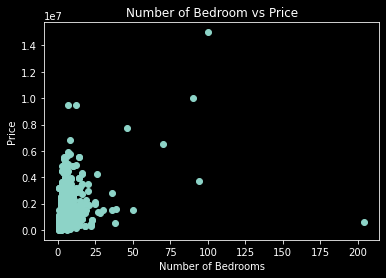

In [312]:
x = bedroom_dropna['Bedrooms']
y = bedroom_dropna['Price']
plt.scatter(x, y)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.title('Number of Bedroom vs Price')
plt.show()
plt.style.use('dark_background')

## 14. Garden

In [313]:
houses.groupby(['Garden']).count().iloc[:,:1]

,Unnamed: 0
Garden,
Yes,848


In [314]:
houses.loc[:, 'Garden']

0        NaN
3        NaN
4        NaN
5        NaN
6        NaN
        ... 
14592    NaN
14609    NaN
14612    NaN
14614    NaN
14615    NaN
Name: Garden, Length: 8747, dtype: object

In [315]:
gar_uniq = houses['Garden'].unique()
gar_uniq

array([nan, 'Yes'], dtype=object)

In [316]:
houses.Garden.isnull().sum()

7899

In [317]:
houses.Garden.isnull().sum()*100/len(houses)

90.30524751343317

The percentage of missing value is 90%, it is quite high

In [318]:
print(houses['Garden'].isnull().sum())
print(houses['Garden surface'].isnull().sum())

houses['Garden'] = houses['Garden'].fillna(houses['Garden surface'].notnull())

7899
6656


Although there are missing values in Garden column there are values in the related index of Garden surface column. Therefore I filled these data points as binary value according to Garden surface column.

In [319]:
def garden_conv(value : str) -> int:
    if value == False: 
        return 0
    elif value == True:
        return 1

houses['Garden'] = houses['Garden'].apply(garden_conv)
houses['Garden'].unique()

array([ 0.,  1., nan])

## 15. Garden Surface

In [320]:
houses.groupby(['Garden surface']).count().iloc[:, -1]

Garden surface
1.0         0
2.0         0
4.0         0
5.0         0
6.0         0
           ..
66441.0     0
80778.0     0
150000.0    0
203900.0    0
950002.0    0
Name: Date of the sale, Length: 630, dtype: int64

In [321]:
houses['Garden surface'].isnull().sum()

6656

The percentage of missing value is 77.66

## THE FINAL RESULT

In [322]:
houses.drop(houses.columns.difference(['Immoweb ID', 'Eur/m2', 'Price HTML', 'Garden surface', 'url address', 'Property type', 'property sub-type', 'Price', 'Price (sr only)', 'Extra', 'Post code', 'Construction year', 'Kitchen type', 'Bedrooms', 'Terrace surface', 'Swimming pool', 'Garden', 'Living area', 'Energy class', 'Building condition', 'Double glazing', 'Surface of the plot' ]), 1, inplace=True)
houses

/var/folders/d1/8xyd7pjd39940tkljh7m_crm0000gp/T/ipykernel_9112/2321825642.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  houses.drop(houses.columns.difference(['Immoweb ID', 'Eur/m2', 'Price HTML', 'Garden surface', 'url address', 'Property type', 'property sub-type', 'Price', 'Price (sr only)', 'Extra', 'Post code', 'Construction year', 'Kitchen type', 'Bedrooms', 'Terrace surface', 'Swimming pool', 'Garden', 'Living area', 'Energy class', 'Building condition', 'Double glazing', 'Surface of the plot' ]), 1, inplace=True)


,Immoweb ID,Property type,property sub-type,Price,Eur/m2,Extra,Post code,Construction year,Building condition,Living area,Kitchen type,Bedrooms,Terrace surface,Energy class,Double glazing,url address,Swimming pool,Garden surface,Garden,Surface of the plot
0,9739983,1,PENTHOUSE,476000,3051.282051,NaN,1130,2017,4,156,10.0,3.0,43.0,6.5,2.0,https://www.immoweb.be/en/classified/penthouse...,NaN,NaN,0.0,NaN
3,9737424,1,PENTHOUSE,399000,3800.000000,NaN,1200,1992,3,105,4.0,2.0,42.0,5.0,NaN,https://www.immoweb.be/en/classified/penthouse...,0.0,NaN,0.0,NaN
4,9737272,1,PENTHOUSE,499000,3118.750000,NaN,1190,2018,4,160,10.0,3.0,11.0,6.0,2.0,https://www.immoweb.be/en/classified/penthouse...,0.0,NaN,0.0,NaN
5,9737235,1,PENTHOUSE,1495000,7119.047619,NaN,1050,2019,4,210,10.0,4.0,100.0,6.0,2.0,https://www.immoweb.be/en/classified/penthouse...,NaN,NaN,0.0,NaN
6,9729720,1,PENTHOUSE,179000,2841.269841,NaN,1140,1970,3,63,7.0,1.0,9.0,1.5,2.0,https://www.immoweb.be/en/classified/penthouse...,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14592,9353716,1,SERVICE_FLAT,299000,4211.267606,NaN,9500,0,4,71,10.0,1.0,16.0,7.0,NaN,https://www.immoweb.be/en/classified/service-f...,0.0,NaN,0.0,NaN
14609,8931427,1,SERVICE_FLAT,286000,4400.000000,NaN,9100,0,3,65,NaN,1.0,NaN,NaN,2.0,https://www.immoweb.be/en/classified/service-f...,10.0,NaN,0.0,NaN
14612,9653921,1,SERVICE_FLAT,250000,3968.253968,NaN,9000,0,4,63,4.0,1.0,5.0,NaN,NaN,https://www.immoweb.be/en/classified/service-f...,NaN,NaN,0.0,NaN
14614,9540791,1,SERVICE_FLAT,369000,6709.090909,NaN,8400,2021,4,55,NaN,1.0,NaN,NaN,NaN,https://www.immoweb.be/en/classified/service-f...,NaN,NaN,0.0,NaN


In [323]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 0 to 14615
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Immoweb ID           8747 non-null   int64  
 1   Property type        8747 non-null   int64  
 2   property sub-type    8747 non-null   object 
 3   Price                8747 non-null   int64  
 4   Eur/m2               8747 non-null   float64
 5   Extra                959 non-null    float64
 6   Post code            8747 non-null   int64  
 7   Construction year    8747 non-null   int64  
 8   Building condition   8747 non-null   int64  
 9   Living area          8747 non-null   int64  
 10  Kitchen type         6550 non-null   float64
 11  Bedrooms             8109 non-null   float64
 12  Terrace surface      3722 non-null   float64
 13  Energy class         6844 non-null   float64
 14  Double glazing       6931 non-null   float64
 15  url address          8747 non-null   

Pearson Method

The method gives information about the correlation, as well as the direction of the relationship between two continous variables



In [324]:
a = houses.corr(method = 'pearson', min_periods = 1)
a

,Immoweb ID,Property type,Price,Eur/m2,Extra,Post code,Construction year,Building condition,Living area,Kitchen type,Bedrooms,Terrace surface,Energy class,Double glazing,Swimming pool,Garden surface,Garden,Surface of the plot
Immoweb ID,1.000000,0.069241,-0.091552,-0.039882,-0.066286,-0.047854,-0.002298,-0.066707,-0.042088,-0.031191,-0.035370,-0.000680,-0.024336,0.034728,-0.032995,-0.057753,0.078376,-0.089296
Property type,0.069241,1.000000,0.245416,-0.209870,NaN,0.044865,-0.080494,-0.285993,0.347943,-0.137475,0.294425,0.050876,-0.206957,0.033373,0.285247,0.036166,0.256189,NaN
Price,-0.091552,0.245416,1.000000,0.222326,0.437888,-0.114504,0.072914,0.114684,0.558398,0.157841,0.407173,0.093207,0.067042,0.025557,0.309481,0.178540,0.055908,0.396942
Eur/m2,-0.039882,-0.209870,0.222326,1.000000,0.287755,-0.033441,0.065266,0.180641,-0.113452,0.114398,-0.066957,-0.012062,0.100442,-0.013343,-0.017191,0.011213,-0.066502,0.173919
Extra,-0.066286,NaN,0.437888,0.287755,1.000000,-0.098233,0.117930,0.408997,0.316128,0.628538,0.077311,0.293511,0.517327,0.161842,0.804586,0.182358,-0.008071,0.216007
Post code,-0.047854,0.044865,-0.114504,-0.033441,-0.098233,1.000000,-0.064681,0.029261,-0.018735,-0.111177,-0.023418,0.001054,0.172104,-0.111431,-0.021811,-0.011091,-0.070663,0.008129
Construction year,-0.002298,-0.080494,0.072914,0.065266,0.117930,-0.064681,1.000000,0.091201,-0.017266,0.056928,-0.015736,-0.020294,0.128092,-0.014847,0.054589,-0.039030,0.064240,-0.028988
Building condition,-0.066707,-0.285993,0.114684,0.180641,0.408997,0.029261,0.091201,1.000000,-0.079612,0.347320,-0.094036,0.012894,0.443791,0.084851,0.047538,-0.016290,-0.023734,0.014981
Living area,-0.042088,0.347943,0.558398,-0.113452,0.316128,-0.018735,-0.017266,-0.079612,1.000000,-0.005749,0.478322,0.210614,-0.018237,-0.001344,0.270956,0.132244,0.082786,0.193224
Kitchen type,-0.031191,-0.137475,0.157841,0.114398,0.628538,-0.111177,0.056928,0.347320,-0.005749,1.000000,-0.052871,0.041226,0.183948,0.084332,0.075941,0.001783,0.006425,0.016732


In [325]:
a['Price'].sort_values(ascending = False)

Price                  1.000000
Living area            0.558398
Extra                  0.437888
Bedrooms               0.407173
Surface of the plot    0.396942
Swimming pool          0.309481
Property type          0.245416
Eur/m2                 0.222326
Garden surface         0.178540
Kitchen type           0.157841
Building condition     0.114684
Terrace surface        0.093207
Construction year      0.072914
Energy class           0.067042
Garden                 0.055908
Double glazing         0.025557
Immoweb ID            -0.091552
Post code             -0.114504
Name: Price, dtype: float64

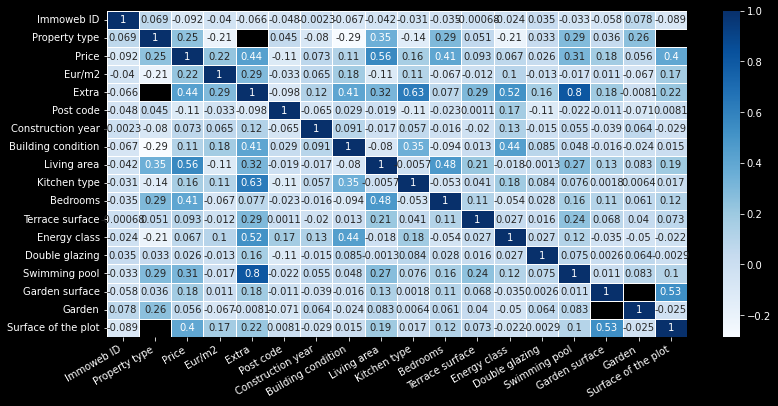

In [326]:
import seaborn as sns
plt.style.use('dark_background')
plt.figure(figsize=(13, 6))
sns.heatmap(a, vmax=1, annot=True, linewidths=.5,  cmap="Blues")
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

Text(0, 0.5, 'Price')

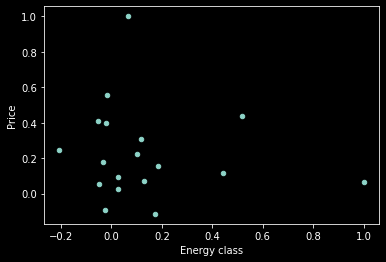

In [327]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
ax = a.plot.scatter(x='Energy class', y='Price', sharex=False)
ax.set_xlabel('Energy class')
ax.set_ylabel('Price')

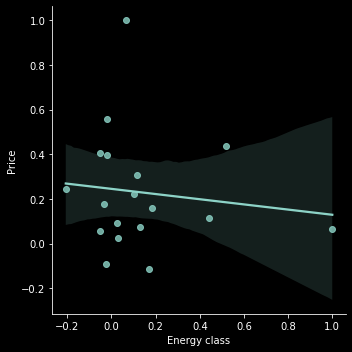

In [328]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Energy class', y='Price', data=a)


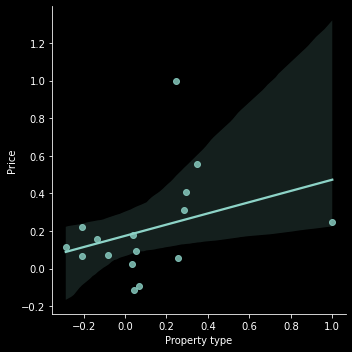

In [329]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Property type', y='Price', data=a)

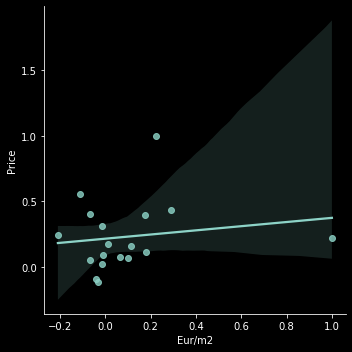

In [330]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Eur/m2', y='Price', data=a)

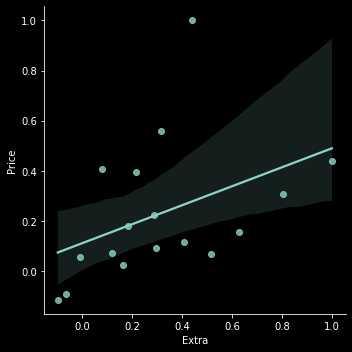

In [331]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Extra', y='Price', data=a)

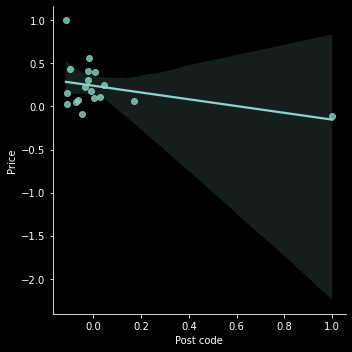

In [332]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Post code', y='Price', data=a)

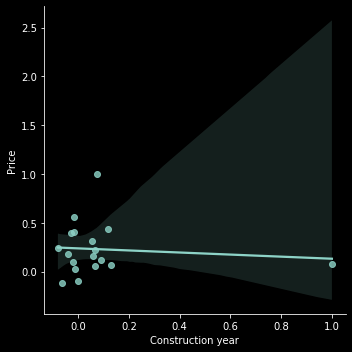

In [333]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Construction year', y='Price', data=a)

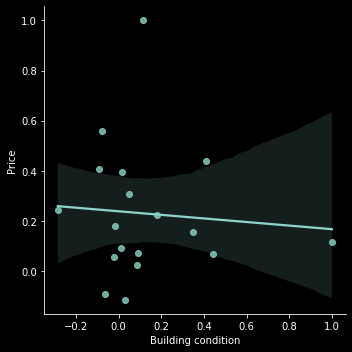

In [334]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Building condition', y='Price', data=a)

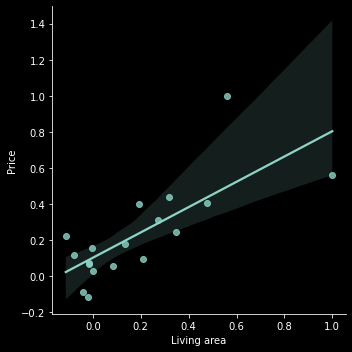

In [335]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Living area', y='Price', data=a)

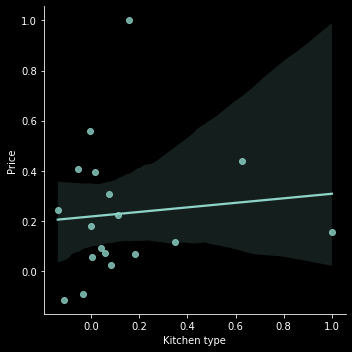

In [336]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Kitchen type', y='Price', data=a)

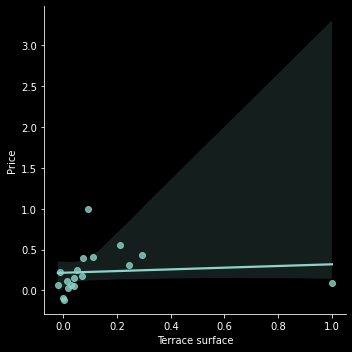

In [337]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Terrace surface', y='Price', data=a)

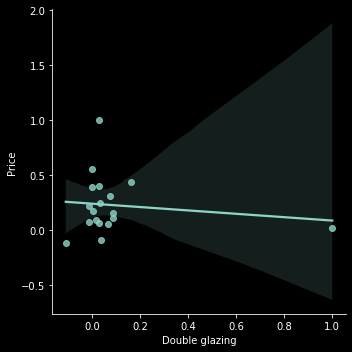

In [338]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Double glazing', y='Price', data=a)

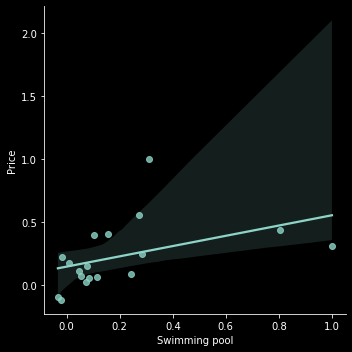

In [339]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Swimming pool', y='Price', data=a)

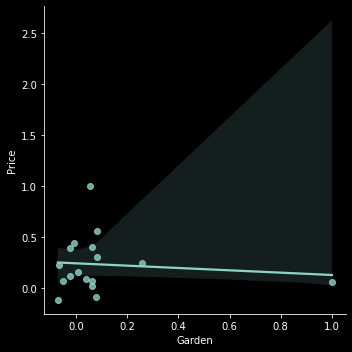

In [340]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Garden', y='Price', data=a)

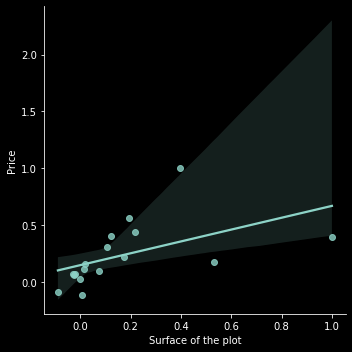

In [341]:
import seaborn as sns
plt.style.use('dark_background')
ax = sns.lmplot(x='Surface of the plot', y='Price', data=a)

Spearman Method

The method determines the strength and direction of the monotonic relationship between two variables. A monotonic relationship is a relationship that does one of the following: (1) as the value of one variable increases, so does the value of the other variable; or (2) as the value of one variable increases, the other variable value decreases

In [342]:
b = houses.corr(method='spearman')


## Municipality

In [343]:
#houses.drop(houses.columns.difference(['Immoweb ID', 'url address', 'Property type', 'property sub-type', 'Price', 'Price (sr only)', 'Extra', 'Post code', 'Construction year', 'Kitchen type', 'Bedrooms', 'Terrace surface', 'Swimming pool', 'Garden', 'Living area', 'Energy class', 'Building condition', 'Double glazing', 'Surface of the plot' ]), 1, inplace=True)
#houses.info()

In [344]:
houses = houses.rename(columns={"Tenement building" : "Municipality"})
mylist = []

for elem in houses['url address']:
    name = elem.split("/")
    mylist.append(name[7])

houses["Municipality"] = mylist
houses['Municipality']

0                haren-(bru.)
3        woluwe-saint-lambert
4                      forest
5                     ixelles
6                       evere
                 ...         
14592          geraardsbergen
14609            sint-niklaas
14612                    gent
14614                oostende
14615                  aalter
Name: Municipality, Length: 8747, dtype: object

### Changing the datatype of Post code

In [345]:
houses['Post code'] = houses['Post code'].astype(int)

In [346]:
houses = houses.rename(columns={"Heating type":"Region"})
for x in houses:
    if x == "Post code":
        for code in houses[x]:
            if code >= 9000 and code <= 9999:
                houses.loc[houses["Post code"] == code, "Region"] = "East Flanders Province"
            if code >= 1000 and code <= 1299:
                houses.loc[houses["Post code"] == code, "Region"] = "Brussels Capital Region"
            if code >= 1300 and code <= 1499:
                houses.loc[houses["Post code"] == code, "Region"] = "Walloon Brabant Province"
            if code >= 1500 and code <= 1999:
                houses.loc[houses["Post code"] == code, "Region"] = "Flemish Brabant Province"
            if code >= 2000 and code <= 2999:
                houses.loc[houses["Post code"] == code, "Region"] = "Antwerp Province"
            if code >= 3000 and code <= 3499:
                houses.loc[houses["Post code"] == code, "Region"] = "Flemish Brabant Province"
            if code >= 3500 and code <= 3999:
                houses.loc[houses["Post code"] == code, "Region"] = "Limburg Province"
            if code >= 4000 and code <= 4999:
                houses.loc[houses["Post code"] == code, "Region"] = "Liège Province"
            if code >= 5000 and code <= 5999:
                houses.loc[houses["Post code"] == code, "Region"] = "Namur Province"
            if code >= 6000 and code <= 6599:
                houses.loc[houses["Post code"] == code, "Region"] = "Hainaut Province"
            if code >= 6600 and code <= 6999:
                houses.loc[houses["Post code"] == code, "Region"] = "Luxembourg Province"
            if code >= 7000 and code <= 7999:
                houses.loc[houses["Post code"] == code, "Region"] = "Hainaut Province"
            if code >= 8000 and code <= 8999:
                houses.loc[houses["Post code"] == code, "Region"] = "West Flanders Province"
            if code >= 9000 and code <= 9999:
                houses.loc[houses["Post code"] == code, "Region"] = "East Flanders Province"

houses['Immoweb ID'].count()
houses['Region']

In [347]:
houses['Immoweb ID'].count()
houses['Region']

0        Brussels Capital Region
3        Brussels Capital Region
4        Brussels Capital Region
5        Brussels Capital Region
6        Brussels Capital Region
                  ...           
14592     East Flanders Province
14609     East Flanders Province
14612     East Flanders Province
14614     West Flanders Province
14615     East Flanders Province
Name: Region, Length: 8747, dtype: object

In [348]:
houses.to_csv('/Users/nadanadia/Downloads/Pythons/clean_data_nadia.csv')

# Compile the data based on postcode

Calculate the value of post code descending

In [349]:
houses2= houses["Post code"].value_counts(ascending=False)
houses2


1000    208
1180    193
1050    179
8300    145
2000    139
       ... 
6661      1
1461      1
7621      1
5564      1
7032      1
Name: Post code, Length: 847, dtype: int64

Delete if the total of house is less than 10 per post code

In [350]:
print("Total no of Post code where data is more than 10 = %s" % (len(houses2[houses2 > 10])))
print("Total no of Post code where data is less than 10 = %s" % (len(houses2[houses2 <= 10])))

Total no of Post code where data is more than 10 = 191
Total no of Post code where data is less than 10 = 656


In [351]:
less_10 = houses2[houses2 <= 10]
houses2 = houses["Post code"].apply(lambda x: 'other' if x in less_10 else x)
len(houses2.unique())

192

In [352]:
houses["Post code"] = houses2

# Dummies

In [353]:
data_dummies = pd.get_dummies(houses, columns=['property sub-type', 'Post code'], drop_first=True)
data_dummies.head() 


,Immoweb ID,Property type,Price,Eur/m2,Extra,Construction year,Building condition,Living area,Kitchen type,Bedrooms,...,Post code_9500,Post code_9550,Post code_9600,Post code_9620,Post code_9700,Post code_9880,Post code_9890,Post code_9900,Post code_9940,Post code_other
0,9739983,1,476000,3051.282051,NaN,2017,4,156,10.0,3.0,...,0,0,0,0,0,0,0,0,0,1
3,9737424,1,399000,3800.000000,NaN,1992,3,105,4.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,9737272,1,499000,3118.750000,NaN,2018,4,160,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,9737235,1,1495000,7119.047619,NaN,2019,4,210,10.0,4.0,...,0,0,0,0,0,0,0,0,0,0
6,9729720,1,179000,2841.269841,NaN,1970,3,63,7.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [354]:
data_dummies.to_csv('/Users/nadanadia/Downloads/Pythons/data_dummies.csv')

# Make Price as Log

In [355]:
log_price = np.log(data_dummies['Price'])

# Then we add it to our data frame
data_dummies['log_price'] = log_price
data_dummies

,Immoweb ID,Property type,Price,Eur/m2,Extra,Construction year,Building condition,Living area,Kitchen type,Bedrooms,...,Post code_9550,Post code_9600,Post code_9620,Post code_9700,Post code_9880,Post code_9890,Post code_9900,Post code_9940,Post code_other,log_price
0,9739983,1,476000,3051.282051,NaN,2017,4,156,10.0,3.0,...,0,0,0,0,0,0,0,0,1,13.073173
3,9737424,1,399000,3800.000000,NaN,1992,3,105,4.0,2.0,...,0,0,0,0,0,0,0,0,0,12.896717
4,9737272,1,499000,3118.750000,NaN,2018,4,160,10.0,3.0,...,0,0,0,0,0,0,0,0,0,13.120361
5,9737235,1,1495000,7119.047619,NaN,2019,4,210,10.0,4.0,...,0,0,0,0,0,0,0,0,0,14.217637
6,9729720,1,179000,2841.269841,NaN,1970,3,63,7.0,1.0,...,0,0,0,0,0,0,0,0,0,12.095141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14592,9353716,1,299000,4211.267606,NaN,0,4,71,10.0,1.0,...,0,0,0,0,0,0,0,0,0,12.608199
14609,8931427,1,286000,4400.000000,NaN,0,3,65,NaN,1.0,...,0,0,0,0,0,0,0,0,0,12.563747
14612,9653921,1,250000,3968.253968,NaN,0,4,63,4.0,1.0,...,0,0,0,0,0,0,0,0,0,12.429216
14614,9540791,1,369000,6709.090909,NaN,2021,4,55,NaN,1.0,...,0,0,0,0,0,0,0,0,0,12.818552


In [356]:
data_dummies = data_dummies.drop(['Price'], axis=1)

In [357]:
data_dummies.head() 

,Immoweb ID,Property type,Eur/m2,Extra,Construction year,Building condition,Living area,Kitchen type,Bedrooms,Terrace surface,...,Post code_9550,Post code_9600,Post code_9620,Post code_9700,Post code_9880,Post code_9890,Post code_9900,Post code_9940,Post code_other,log_price
0,9739983,1,3051.282051,NaN,2017,4,156,10.0,3.0,43.0,...,0,0,0,0,0,0,0,0,1,13.073173
3,9737424,1,3800.000000,NaN,1992,3,105,4.0,2.0,42.0,...,0,0,0,0,0,0,0,0,0,12.896717
4,9737272,1,3118.750000,NaN,2018,4,160,10.0,3.0,11.0,...,0,0,0,0,0,0,0,0,0,13.120361
5,9737235,1,7119.047619,NaN,2019,4,210,10.0,4.0,100.0,...,0,0,0,0,0,0,0,0,0,14.217637
6,9729720,1,2841.269841,NaN,1970,3,63,7.0,1.0,9.0,...,0,0,0,0,0,0,0,0,0,12.095141


# Regression

https://www.freecodecamp.org/news/how-to-build-and-train-linear-and-logistic-regression-ml-models-in-python/

In [358]:
from sklearn.model_selection import train_test_split 
houses = data_dummies.drop(columns=['Immoweb ID', 'url address', 'Municipality', 'Region'], axis=1)

#get rid of infinite values
houses.replace([np.inf, -np.inf], np.nan, inplace=True)
#get rid null values
houses.fillna(0, inplace=True)


In [359]:
X = houses.drop(['log_price'], axis =1)
y = houses['log_price']
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (8747, 226)
y shape :  (8747,)


In [360]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (6997, 226)
Shape of X_test:  (1750, 226)
Shape of y_train:  (6997,)
Shape of y_test:  (1750,)


# Train the model

In [361]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_train, y_train)

0.7106689918193991

In [375]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_test, y_test)
regressor.score(X_test, y_test)

0.8607639354434523

In [363]:
regressor.coef_ 

array([ 6.52385939e-01,  1.86073611e-04, -2.04437096e-03,  2.83930171e-05,
        7.81213352e-02,  1.61200827e-03,  6.81109933e-03,  3.42448207e-03,
       -1.03966567e-04,  8.78384888e-03,  9.03813895e-03,  1.90865790e-02,
        2.08207764e-06, -5.49810433e-04,  5.85411159e-02, -1.83191437e-01,
       -2.43171247e-01, -1.26693446e+00, -9.23704569e-02,  2.58704117e-01,
        9.76839041e-02,  1.78749309e-01, -6.82088734e-01,  1.16985287e-01,
       -1.38615113e+00,  5.23865167e-01,  2.98782697e-01,  7.12519292e-02,
       -8.80946962e-02, -2.17481083e-01,  2.98031891e-01, -1.20970317e-01,
       -1.78435434e-01,  3.39237777e-01,  9.41534081e-02,  3.02724805e-02,
       -1.41465189e-02,  2.20212223e-01,  1.61501037e-01,  4.72056731e-02,
       -1.02250610e-01, -8.68117950e-02, -1.03200304e-01,  2.91503062e-02,
       -5.55474790e-02, -2.01567600e-02, -2.28916285e-01,  1.73258863e-01,
        2.99858660e-01,  2.02934060e-01,  4.24161630e-02, -1.35612741e-03,
       -1.12234683e-01, -

In [364]:
regressor.intercept_

10.753574268850137

In [385]:
pd.DataFrame(regressor.coef_, x, columns = ['Coeff'])

TypeError: Index(...) must be called with a collection of some kind, 'Municipality' was passed

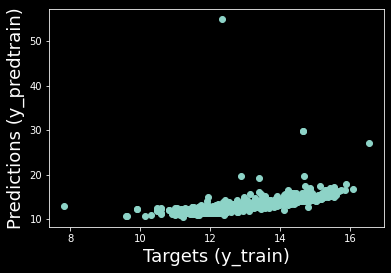

In [379]:
y_predtrain = regressor.predict(X_train)
plt.scatter(y_train, y_predtrain)
plt.xlabel("Targets (y_train)", size=18)
plt.ylabel("Predictions (y_predtrain)", size=18)
plt.show()

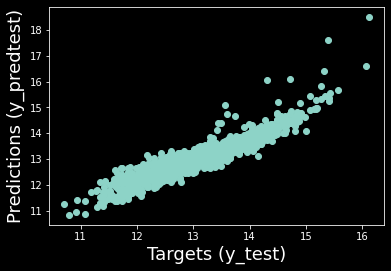

In [380]:
y_predtest = regressor.predict(X_test)
plt.scatter(y_test, y_predtest)
plt.xlabel("Targets (y_test)", size=18)
plt.ylabel("Predictions (y_predtest)", size=18)
plt.show()

Now that we have trained our algorithm, it's time to make some predictions. 

In [382]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
y_predtrain = regressor.predict(X_train)
rmse = (np.sqrt(MSE(y_train, y_predtrain)))
r2 = r2_score(y_train, y_predtrain)
print("The model result for training set")
print("RMSE is {}".format(rmse))
print("R2 score is {}".format(r2))

y_predtest = regressor.predict(X_test)
rmse = (np.sqrt(MSE(y_test, y_predtest)))
r2 = r2_score(y_test, y_predtest)
print("\n")
print("The model result for testing set")
print("RMSE is {}".format(rmse))
print("R2 score is {}".format(r2))


The model result for training set
RMSE is 0.6864648136487238
R2 score is 0.19202575625537333


The model result for testing set
RMSE is 0.2842918589727888
R2 score is 0.8607639354434523
